<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256-128/resized/15*15/caltech_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-128.zip -d caltech-256-image-128

Streaming output truncated to the last 5000 lines.
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0001.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0248.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0644.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0768.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0404.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0303.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0109.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0122.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0745.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0043.jpg  
  inflating: caltech-256-image-128/caltech-256-image-128/airplanes-101.251_0325.jpg  
  i

In [14]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 1
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
DATA_DIRECTORY = "caltech-256-image-128/caltech-256-image-128/"

In [15]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

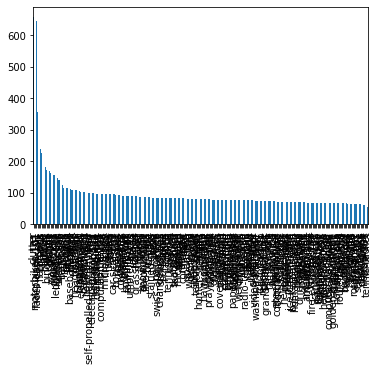

In [17]:
train_df['category'].value_counts().plot.bar()

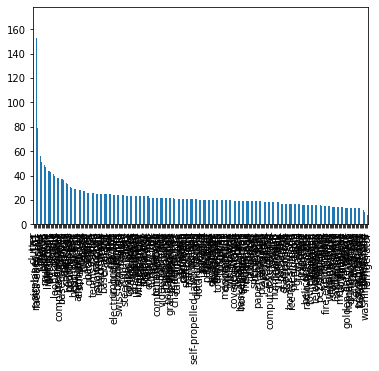

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [20]:
validation_datagen = ImageDataGenerator(
    # fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


In [21]:
train_generator.image_shape

(128, 128, 3)

In [22]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

257


In [23]:
# # Importing the Keras libraries and packages
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Basic ResNet Building Block 
# def resnet_layer(inputs, num_filters = 16, kernel_size = 3, strides = 1, 
#                  activation ='relu', batch_normalization = True, 
#     conv = Conv2D(num_filters, kernel_size = kernel_size, strides = strides, 
#                   padding ='same', kernel_initializer ='he_normal', 
#                   kernel_regularizer = l2(1e-4)) 
  
#     x = inputs 
#     if conv_first: 
#         x = conv(x) 
#         if batch_normalization: 
#             x = BatchNormalization()(x) 
#         if activation is not None: 
#             x = Activation(activation)(x) 
#     else: 
#         if batch_normalization: 
#             x = BatchNormalization()(x) 
#         if activation is not None: 
#             x = Activation(activation)(x) 
#         x = conv(x) 
#     return x

# def _residual_block_first(self, x, out_channel, strides, name="unit"):
#     in_channel = x.get_shape().as_list()[-1]
#     with tf.variable_scope(name) as scope:
#         print('\tBuilding residual unit: %s' % scope.name)

#         # Shortcut connection
#         if in_channel == out_channel:
#             if strides == 1:
#                 shortcut = tf.identity(x)
#             else:
#                 shortcut = tf.nn.max_pool(x, [1, strides, strides, 1], [1, strides, strides, 1], 'VALID')
#         else:
#             shortcut = self._conv(x, 1, out_channel, strides, name='shortcut')
#         # Residual
#         x = self._conv(x, 3, out_channel, strides, name='conv_1')
#         x = self._bn(x, name='bn_1')
#         x = self._relu(x, name='relu_1')
#         x = self._conv(x, 3, out_channel, 1, name='conv_2')
#         x = self._bn(x, name='bn_2')
#         # Merge
#         x = x + shortcut
#         x = self._relu(x, name='relu_2')
#     return x

# def resnet_v1(input_shape, depth, num_classes = 10): 
      
#     if (depth - 2) % 6 != 0: 
#         raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])') 
#     # Start model definition. 
#     num_filters = 16
#     num_res_blocks = int((depth - 2) / 6) 
  
#     inputs = Input(shape = input_shape) 
#     x = resnet_layer(inputs = inputs) 
#     # Instantiate the stack of residual units 
#     for stack in range(3): 
#         for res_block in range(num_res_blocks): 
#             strides = 1
#             if stack > 0 and res_block == 0:  # first layer but not first stack 
#                 strides = 2  # downsample 
#             y = resnet_layer(inputs = x, 
#                              num_filters = num_filters, 
#                              strides = strides) 
#             y = resnet_layer(inputs = y, 
#                              num_filters = num_filters, 
#                              activation = None) 
#             if stack > 0 and res_block == 0:  # first layer but not first stack 
#                 # linear projection residual shortcut connection to match 
#                 # changed dims 
#                 x = resnet_layer(inputs = x, 
#                                  num_filters = num_filters, 
#                                  kernel_size = 1, 
#                                  strides = strides, 
#                                  activation = None, 
#                                  batch_normalization = False) 
#             x = keras.layers.add([x, y]) 
#             x = Activation('relu')(x) 
#         num_filters *= 2
  
#     # Add classifier on top. 
#     # v1 does not use BN after last shortcut connection-ReLU 
#     x = AveragePooling2D(pool_size = 8)(x) 
#     y = Flatten()(x) 
#     outputs = Dense(num_classes, 
#                     activation ='softmax', 
#                     kernel_initializer ='he_normal')(y) 
  
#     # Instantiate model. 
#     model = Model(inputs = inputs, outputs = outputs) 
#     return model


In [24]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Add, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

def res_identity(x, filters): 
  #resnet block where dimension does not change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x

def resnet50(kernel_size, image_shape, num_classes):

  input_layer = Input(shape=image_shape)
  # x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  x =Conv2D(64, kernel_size=kernel_size, strides=(2,2), name="GaborLayer")(input_layer)
  # x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_layer, outputs=x, name='Resnet50')
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  

  return model

classifier = resnet50(GABOR_SIZE, train_generator.image_shape, NUM_CLASSES)
classifier.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
GaborLayer (Conv2D)             (None, 57, 57, 64)   43264       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 57, 57, 64)   256         GaborLayer[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 57, 57, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 151s 186ms/step - loss: 21.9144 - accuracy: 0.0329 - auc: 0.5702 - val_loss: 10.8103 - val_accuracy: 0.0507 - val_auc: 0.6151
Epoch 2/1000
765/765 [==============================] - 141s 184ms/step - loss: 9.6567 - accuracy: 0.0581 - auc: 0.6557 - val_loss: 16.1205 - val_accuracy: 0.0201 - val_auc: 0.5507
Epoch 3/1000
765/765 [==============================] - 141s 184ms/step - loss: 7.7704 - accuracy: 0.0674 - auc: 0.6811 - val_loss: 6.8078 - val_accuracy: 0.0638 - val_auc: 0.6703
Epoch 4/1000
765/765 [==============================] - 141s 184ms/step - loss: 6.9714 - accuracy: 0.0728 - auc: 0.6891 - val_loss: 7.3851 - val_accuracy: 0.0458 - val_auc: 0.6431
Epoch 5/1000
765/765 [==============================] - 141s 184ms/step - loss: 6.6883 - accuracy: 0.0712 - auc: 0.7018 - val_loss: 433.8180 - val_accuracy: 0.0116 - val_auc: 0.5155
Epoch 6/1000
765/765 [==============================] - 141s 184ms/step - loss: 7.4701 - accura

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
classifier.layers[GABOR_LAYER_INDEX].name

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

In [ ]:
classifier.layers[GABOR_LAYER_INDEX].namefilter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)